In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from acq import UCB, EI, PI, KG, find_next_batch, optimize_acqf
import matplotlib.pyplot as plt
import sys
import os
sys.path.append('../')
sys.path.append("../GaussianProcess")
import GaussianProcess.kernel as kernel
from cigp import CIGP_withMean



## Define the objective function
This objective function represents a simple sum of sine functions. The goal is to demonstrate a basic mathematical function that exhibits periodic behavior with different frequencies. The input 'x' is the variable at which the sine functions are evaluated, and the result is the sum of sin(x) and sin(2x).

In [9]:
def objective_function(x):
    # Simple sum of sine functions for demonstration
    return torch.sin(x)+torch.sin(2*x)

## Initialize prior knowledge with 5 random points

In [10]:
input_dim = 1
num_initial_points = 3
train_x = torch.rand(num_initial_points, input_dim) * 10  # Random points in [0, 10] for each dimension
train_y = objective_function(train_x).reshape(-1,1)

# Initialize the surrogate model
This code initializes a surrogate model for Bayesian optimization. The surrogate model (CIGP_withMean) is equipped with a chosen kernel (ARDKernel) to capture the underlying patterns in the data.  The Adam optimizer is then set up to optimize the model's parameters during the training process. 

In [11]:
kernel1 = kernel.ARDKernel(1,3.0,1.0)
# kernel1 = kernel.MaternKernel(1)
# kernel1 = kernel.LinearKernel(1,-1.0,1.)
# kernel1 = kernel.SumKernel(kernel.LinearKernel(1), kernel.MaternKernel(1))
model = CIGP_withMean(1, 1, kernel=kernel1, noise_variance=4.)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-2)

# Define the mean and variance functions for acq function
The defined mean and variance functions extract the predictive mean and variance from the trained surrogate model (model) when provided with input points (X). These functions are crucial components in the computation of acquisition functions, such as the Upper Confidence Bound (UCB), and are used to guide the selection of the next point for evaluation in the Bayesian optimization process.

In [12]:
def mean_function(X):
    model.eval()
    with torch.no_grad():
        mean, _ = model.forward(train_x, train_y, X)
        return mean

def variance_function(X):
    model.eval()
    with torch.no_grad():
        _, var = model.forward(train_x, train_y, X)
        return var

# Initialize acq function
The code snippet initializes different acquisition functions for Bayesian optimization.

In [13]:
ucb = UCB(mean_function, variance_function, kappa=5)
pi = PI(mean_function, variance_function)
ei = EI(mean_function, variance_function)
kg = KG(mean_function, variance_function, num_fantasies=10)
best_y = []
# use it to remember the key iteration
key_iterations = [2,4,5,6,8,10]
predictions = []
iteration_label = True


# Bayesian optimization loop
The key iterations allow monitoring the model's behavior and predictions at specific points during the optimization process. The overall process aims to iteratively improve the surrogate model and select points for evaluation that are expected to yield the best objective values.

In [14]:
# Bayesian optimization loop
bounds = torch.tensor([[0, 10]] * input_dim)
for iteration in range(10):  # Run for 5 iterations

    for i in range(100):
        optimizer.zero_grad()
        loss = -model.log_likelihood(train_x, train_y)
        loss.backward()
        optimizer.step()
        print('iter', i, 'nll:{:.5f}'.format(loss.item()))


    #batch_points = find_next_batch(ucb, bounds, batch_size=1, n_samples=500, f_best=train_x[np.argmax(train_y)])
    # batch_points = ei.find_next_batch(bounds, batch_size=1, n_samples=1000, f_best=train_x[np.argmax(train_y)])
    #find_next_batch(acq)
    batch_points = optimize_acqf(acq=ucb, raw_samples=50, bounds=bounds, f_best=0, num_restarts=30, options=None)
    batch_points = torch.tensor(batch_points).float()

    # Evaluate the objective function
    new_y = objective_function(batch_points.squeeze()).reshape(-1,1)

    # Update the model
    train_x = torch.cat([train_x, batch_points])
    train_y = torch.cat([train_y, new_y])
    # Store the best objective value found so far
    best_y.append(new_y.max().item())
    # Visualization

    # 在关键迭代时保存模型预测
    if (iteration + 1) in key_iterations:
        model.eval()
        fixed_dims = torch.full((1, input_dim - 1), 5.0)  # Example: set them to the midpoint (5.0)
        test_points = torch.linspace(0, 10, 100)
        test_X = torch.cat((test_points.unsqueeze(1), fixed_dims.expand(test_points.size(0), -1)), 1)
        true_y = objective_function(test_X)

        with torch.no_grad():
            pred_mean, pred_std = model.forward(train_x, train_y, test_X)
            predictions.append((pred_mean, pred_std))


iter 0 nll:7.00639
iter 1 nll:6.98268
iter 2 nll:6.95874
iter 3 nll:6.93458
iter 4 nll:6.91018
iter 5 nll:6.88553
iter 6 nll:6.86062
iter 7 nll:6.83545
iter 8 nll:6.81001
iter 9 nll:6.78427
iter 10 nll:6.75824
iter 11 nll:6.73190
iter 12 nll:6.70523
iter 13 nll:6.67823
iter 14 nll:6.65088
iter 15 nll:6.62317
iter 16 nll:6.59508
iter 17 nll:6.56660
iter 18 nll:6.53771
iter 19 nll:6.50840
iter 20 nll:6.47863
iter 21 nll:6.44841
iter 22 nll:6.41770
iter 23 nll:6.38649
iter 24 nll:6.35475
iter 25 nll:6.32245
iter 26 nll:6.28958
iter 27 nll:6.25610
iter 28 nll:6.22198
iter 29 nll:6.18720
iter 30 nll:6.15171
iter 31 nll:6.11549
iter 32 nll:6.08179
iter 33 nll:6.05434
iter 34 nll:6.02533
iter 35 nll:5.99487
iter 36 nll:5.96303
iter 37 nll:5.92984
iter 38 nll:5.89536
iter 39 nll:5.85960
iter 40 nll:5.82255
iter 41 nll:5.78423
iter 42 nll:5.74461
iter 43 nll:5.70366
iter 44 nll:5.66934
iter 45 nll:5.63459
iter 46 nll:5.59794
iter 47 nll:5.55946
iter 48 nll:5.51918
iter 49 nll:5.47711
iter 50 nl

d:\ANACONDA\envs\water\lib\site-packages\ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


iter 53 nll:16.70521
iter 54 nll:7.30151
iter 55 nll:-2.22781
iter 56 nll:-7.84850
iter 57 nll:11.43802
iter 58 nll:-18.45248
iter 59 nll:-15.00016
iter 60 nll:-10.06289
iter 61 nll:-6.27550
iter 62 nll:-3.90811
iter 63 nll:-2.62584
iter 64 nll:-2.04472
iter 65 nll:-1.82460
iter 66 nll:-1.75977
iter 67 nll:-1.73073
iter 68 nll:-1.60661
iter 69 nll:-1.30428
iter 70 nll:-0.94348
iter 71 nll:-0.86170
iter 72 nll:-1.34035
iter 73 nll:-2.34593
iter 74 nll:-3.60149
iter 75 nll:-4.85245
iter 76 nll:-6.01511
iter 77 nll:-7.15395
iter 78 nll:-8.36210
iter 79 nll:-9.70872
iter 80 nll:-11.22442
iter 81 nll:-12.91287
iter 82 nll:-14.76040
iter 83 nll:-16.71050
iter 84 nll:-18.69326
iter 85 nll:-20.57880
iter 86 nll:-22.30788
iter 87 nll:-24.20626
iter 88 nll:-26.37338
iter 89 nll:-18.07430
iter 90 nll:-25.13631
iter 91 nll:-26.83064
iter 92 nll:-25.28716
iter 93 nll:-24.32582
iter 94 nll:-23.81168
iter 95 nll:-23.59084
iter 96 nll:-23.65828
iter 97 nll:-23.99471
iter 98 nll:-24.63124
iter 99 nll:-

# plot the picture
This visualization helps to understand how well the Gaussian Process model captures the true function and how uncertainty evolves as more samples are acquired during the optimization process.

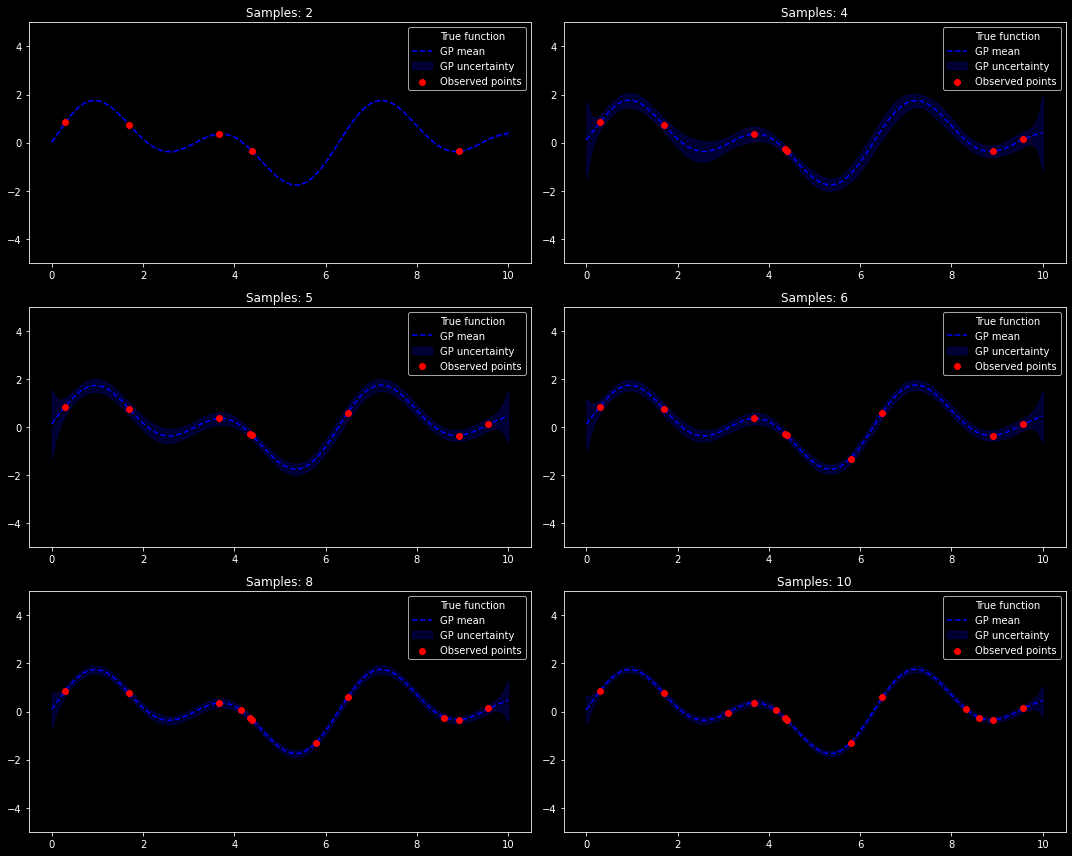

In [15]:
# 绘制子图
plt.figure(figsize=(15, 12))
for i, (pred_mean, pred_std) in enumerate(predictions):
    plt.subplot(3, 2, i+1)
    plt.ylim(-5, 5)
    plt.plot(test_points.numpy(), true_y.numpy(), 'k-', label='True function')
    plt.plot(test_points.numpy(), pred_mean.numpy(), 'b--', label='GP mean')
    plt.fill_between(test_points.numpy().reshape(-1),
                     (pred_mean - 20 * pred_std).numpy().reshape(-1),
                     (pred_mean + 20 * pred_std).numpy().reshape(-1),
                     color='blue', alpha=0.2, label='GP uncertainty')

    observed_x = train_x[:, 0].numpy()  # Only the first dimension for all observed points
    observed_y = train_y.numpy()
    plt.scatter(observed_x[:num_initial_points+key_iterations[i]], observed_y[:num_initial_points+key_iterations[i]], c='r', zorder=3, label='Observed points')
    plt.title(f'Samples: {key_iterations[i]}')
    plt.legend()

plt.tight_layout()
plt.show()
